In [3]:
import torch

print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.device_count())

2.2.2+cu118
True
1


In [4]:
import torch
import torch.nn as nn
from torch import Tensor

In [5]:
#Mnistでの動作確認
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

from torchvision import datasets, transforms

# データセットの読み込み：28x28の画像データ
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

# モデルの定義
class MnistModel(nn.Module):
    def __init__(self):
        super(MnistModel, self).__init__()
        self.fc = nn.Linear(32, 10)
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 32)


    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.fc(x)
        return x
    
model = MnistModel().cuda()

# 損失関数と最適化手法の定義
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 学習
hist_avg_loss = []
hist_train_acc = []
hist_valid_acc = []
model.train()

for epoch in range(20):
    avg_loss = 0
    correct = 0
    total = 0
    for x, t in train_loader:
        x, t = x.cuda(), t.cuda()
        y = model(x)
        loss = criterion(y, t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item()
        _, pred = y.max(1)
        correct += (pred == t).sum().item()
        total += x.size(0)
    avg_loss /= len(train_loader)
    acc = correct / total
    hist_avg_loss.append(avg_loss)
    hist_train_acc.append(acc)

    correct = 0
    total = 0
    for x, t in test_loader:
        x, t = x.cuda(), t.cuda()
        y = model(x)
        _, pred = y.max(1)
        correct += (pred == t).sum().item()
        total += x.size(0)

    acc = correct / total
    hist_valid_acc.append(acc)

    print(f"epoch: {epoch}, avg_loss: {avg_loss}, train_acc: {hist_train_acc[-1]}, valid_acc: {hist_valid_acc[-1]}")


epoch: 0, avg_loss: 0.3567470685918448, train_acc: 0.9021833333333333, valid_acc: 0.9534
epoch: 1, avg_loss: 0.12988521672610534, train_acc: 0.9621166666666666, valid_acc: 0.9639
epoch: 2, avg_loss: 0.0859162557615972, train_acc: 0.9742, valid_acc: 0.9722
epoch: 3, avg_loss: 0.06228411352551822, train_acc: 0.9811333333333333, valid_acc: 0.9769
epoch: 4, avg_loss: 0.046169149484842825, train_acc: 0.9856333333333334, valid_acc: 0.9771
epoch: 5, avg_loss: 0.03594927899321037, train_acc: 0.9888, valid_acc: 0.98
epoch: 6, avg_loss: 0.026593062297891833, train_acc: 0.9919, valid_acc: 0.9794
epoch: 7, avg_loss: 0.022478803459094213, train_acc: 0.9931, valid_acc: 0.9808
epoch: 8, avg_loss: 0.01780202564870768, train_acc: 0.9947, valid_acc: 0.9817
epoch: 9, avg_loss: 0.013081182763829375, train_acc: 0.9960666666666667, valid_acc: 0.9807
epoch: 10, avg_loss: 0.011393408931760506, train_acc: 0.9965, valid_acc: 0.9787
epoch: 11, avg_loss: 0.011712291150918302, train_acc: 0.99635, valid_acc: 0.9771

In [15]:
# モデルの情報を表示
from torchinfo import summary

summary(model, input_size=(784,))

Layer (type:depth-idx)                   Output Shape              Param #
MnistModel                               [10]                      --
├─Linear: 1-1                            [512]                     401,920
├─Linear: 1-2                            [32]                      16,416
├─Linear: 1-3                            [10]                      330
Total params: 418,666
Trainable params: 418,666
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 206.31
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 1.67
Estimated Total Size (MB): 1.68

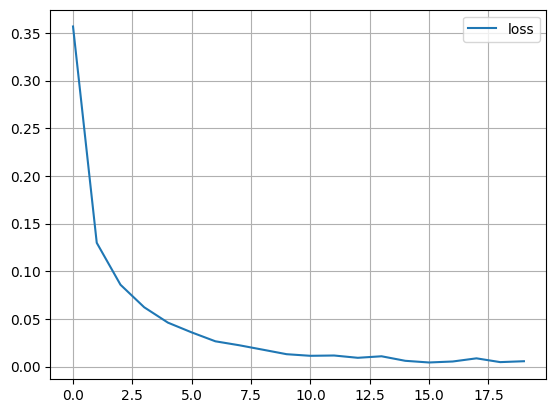

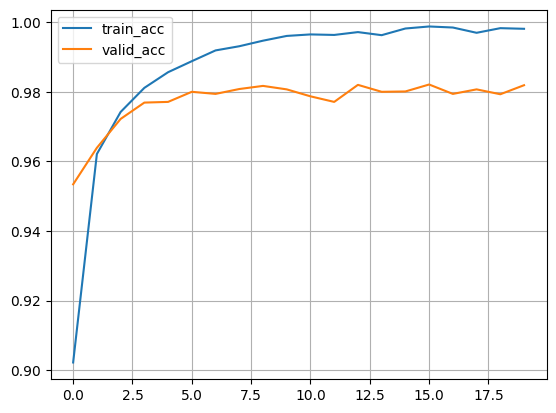

In [8]:
# 学習曲線の表示
import matplotlib.pyplot as plt

# 損失と精度の推移
plt.figure()
plt.plot(hist_avg_loss, label="loss")
plt.legend()
plt.grid()

plt.figure()
plt.plot(hist_train_acc, label="train_acc")
plt.plot(hist_valid_acc, label="valid_acc")
plt.legend()
plt.grid()

plt.show()

In [9]:
# モデルの保存
torch.save(model.state_dict(), "mnist_model_linear.pth")